In [1]:
#vae.py
import numpy as np

from keras.models import Model
from keras import backend as K
from keras.regularizers import l1
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, Dropout
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# CIFAR dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype('float32')/256.0) #- 0.5
x_test = (x_test.astype('float32')/256.0) #- 0.5
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
original_dim = 3072 # x_train.shape[1]
print('x shape', x_train.shape, 'y shape', y_train.shape,'x shape', x_test.shape, 'y shape', y_test.shape)
# network parameters
input_shape = (x_train.shape[1:])
intermediate_dim = 1024
batch_size = 1024
latent_dim = 8
dropout_rate = 0.0
epochs = 16

x shape (50000, 32, 32, 3) y shape (50000, 1) x shape (10000, 32, 32, 3) y shape (10000, 1)


In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    #epsilon = K.random_normal(shape=(K.shape(z_mean)+(dim,)))
    epsilon = K.random_normal(shape=(K.shape(z_mean)))
    #epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(256, 3, strides=2, activation='relu', padding='same')(inputs)
x = Dropout(dropout_rate)(x)
x = Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(96, 3, activation='relu', padding='same')(x)
x = Dropout(dropout_rate)(x)
#x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

inner_shape = (8, 8, latent_dim)
# build decoder model
latent_inputs = Input(shape=inner_shape, name='z_sampling')
#x = Dense(intermediate_dim, activation='relu')(latent_inputs)
#x = Reshape((16, 16, 4))(x)
# x = Conv2D(96, 3, activation='relu', padding='same')(latent_inputs)
# x = UpSampling2D(4)(x)
# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = UpSampling2D(4)(x)
# x = Conv2D(160, 3, activation='relu', padding='same')(x)
# x = UpSampling2D(2)(x)
# x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(96, 3, strides=2, activation='relu', padding='same')(latent_inputs)
x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(160, 3, activation='relu', padding='same')(x)
#outputs = Conv2D(3, 1, activation='linear')(x)
outputs = Conv2D(3, 1, activation='sigmoid')(x)


# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 256)  7168        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 256)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 128)    295040      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [5]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_cnn')
vae.summary()
# Compute VAE loss
def vae_loss(y_true, y_pred):
    #reconstruction_loss = original_dim*binary_crossentropy(y_true, y_pred)
    reconstruction_loss = original_dim*mse(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(K.mean(reconstruction_loss) + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

vae.fit(x_train, x_train, shuffle=True, batch_size=batch_size, epochs=epochs, validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 8, 8, 8), (None,  414448    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         302691    
Total params: 717,139
Trainable params: 717,139
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 8, 8, 8), (None,  414448    
_________________________________________________________________
deco

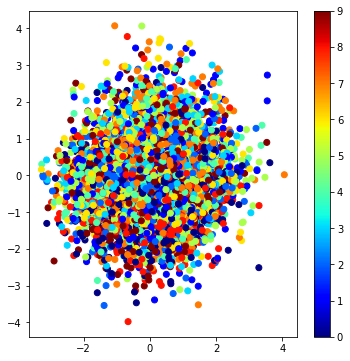

In [10]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0, 0, 0], x_test_encoded[2][:, 0, 0, 1], c=y_test[:,0], cmap='jet')
plt.colorbar()
plt.show()

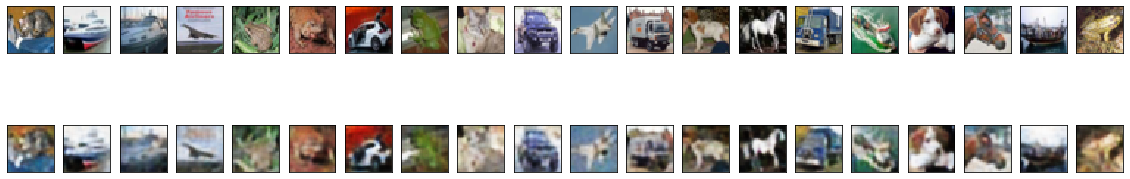

In [11]:
n = 20  # how many digits we will display
image_shape = (32, 32, 3)
plt.figure(figsize=(20, 4))
x_test_generated = vae.predict(x_test, batch_size=batch_size)
x_test_generated2 = decoder.predict(x_test_encoded[2])
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(image_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_generated[i].reshape(image_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

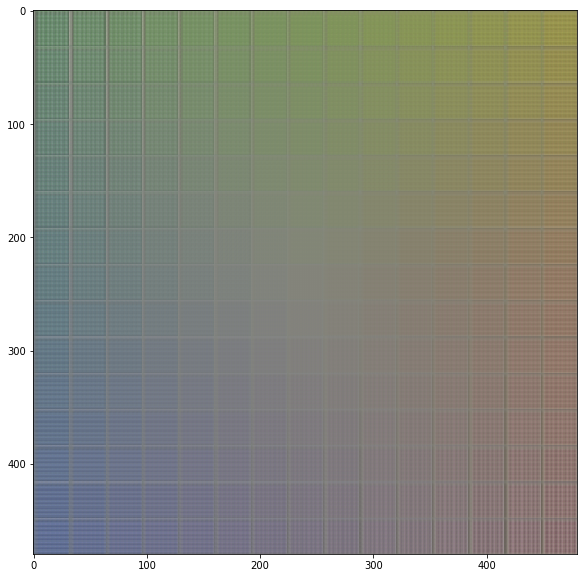

In [25]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = image_shape[0]
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
latent_shape = (1, 16, 16, latent_dim)
z_sample = np.zeros((1, 8, 8, latent_dim))
corners = np.random.normal(size=(4, 1, 8, 8, latent_dim))
#corners = np.random.normal(size=(4, 1, 16, 16, latent_dim))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample[0, :, :, 6] = xi
        z_sample[0, :, :, 7] = yi
        #z_sample = corners[0]*xi*yi + corners[0]*xi*(1-yi) + corners[0]*(1-xi)*yi + corners[0]*(1-xi)*(1-yi)
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(image_shape)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

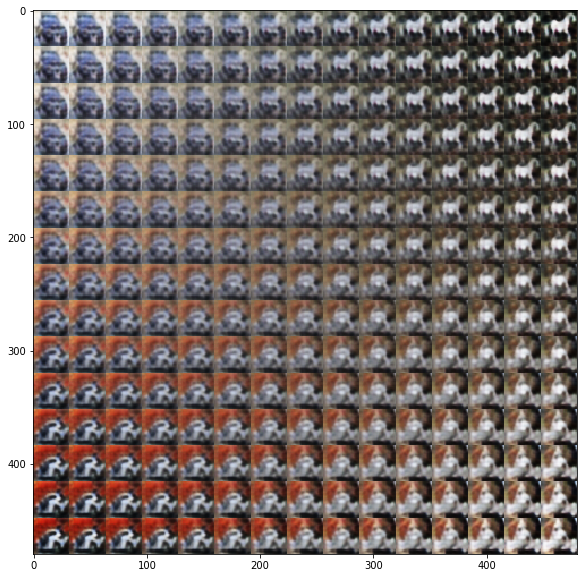

In [30]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)
for i, alpha in enumerate(grid_x):
    for j, alpha2 in enumerate(grid_x):
        z = (alpha*alpha2*x_test_encoded[2][16])
        z += ((1-alpha)*alpha2*x_test_encoded[2][6])
        z += (alpha*(1-alpha2)*x_test_encoded[2][13])
        z += ((1-alpha)*(1-alpha2)*x_test_encoded[2][9])
        z = np.expand_dims(z, axis = 0)
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(image_shape)
        figure[j * digit_size: (j + 1) * digit_size, i * digit_size: (i + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()